In [67]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import datetime as dt
import time
import yfinance as yf
import seaborn as sns   

plt.style.use('ggplot')

### Data Preprocessing

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Fechamento BTC-USD'}, xlabel='Date'>

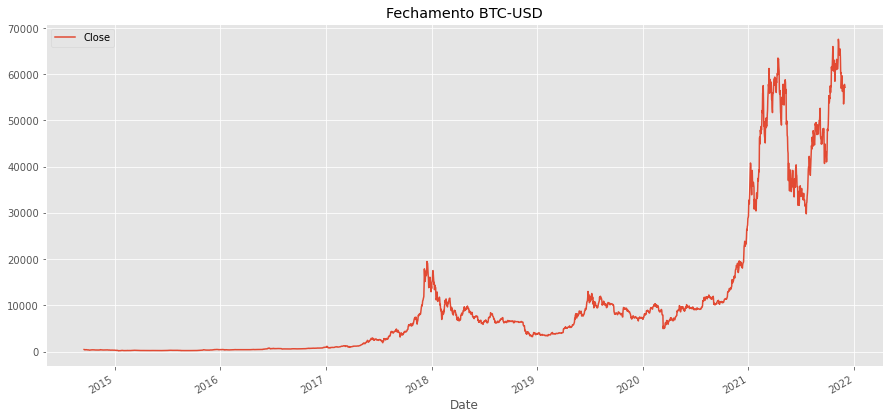

In [68]:
# Loading the dataset
p = '10y'
i = '1d'

df = yf.download(tickers='BTC-USD', period = p, interval = i)
df.drop(df[df['Volume']==0].index, inplace = True)
df['Close'].plot(figsize=(15,7), title="Fechamento BTC-USD", legend=True)

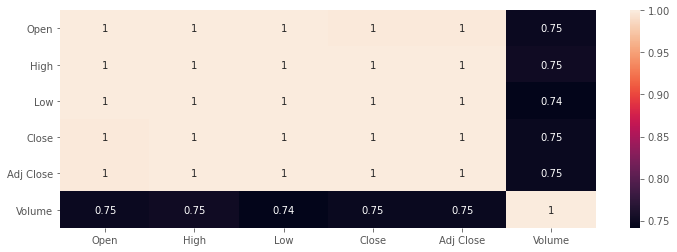

Open         0.998805
High         0.999484
Low          0.999394
Close        1.000000
Adj Close    1.000000
Volume       0.747552
Name: Close, dtype: float64

In [69]:
# Matriz de correlação
plt.figure(figsize=(12,4))
sns.heatmap(df.corr(), annot = True)

plt.show()
df.corr()['Close']

In [70]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    2.628000e+03
mean     1.410258e+10
std      1.993629e+10
min      5.914570e+06
25%      7.531515e+07
50%      4.719100e+09
75%      2.313271e+10
max      3.509679e+11
Name: Volume, dtype: float64


In [71]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

## Funções do modelo

In [72]:
# Função para transformar dados em sequencia do LSTM
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

In [73]:
#Contrói e treina o modelo
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    #Dados de treino e validação
    X_train, Y_train = to_sequential_data(train, timesteps)
    X_val,Y_val = to_sequential_data(val, timesteps)
    
    # Adiciona as camadas do modelo
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]), return_sequences = True, activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Treinamento
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [74]:
# Função para avaliar o modelo
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Laço para os dados de teste
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Predição
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [75]:
# Função para plotar os dados de teste e predição
def plot_data(Y_test,Y_hat):
    plt.figure(figsize=(15,7))
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Dia')
    plt.ylabel('Fechamento')
    plt.title("Predição LSTM-M")
    plt.legend(['Atual','Predito'],loc = 'lower right')
    plt.show()

In [76]:
# Função para plotar erro
def plot_error(train_loss,val_loss):
    plt.figure(figsize=(15,7))
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Construção do Modelo

In [77]:
# Extraindo as séries
features = ['Close', 'Open', 'Low', 'High']
series = df[features] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(2628, 4)
                   Close          Open           Low          High
Date                                                              
2021-11-26  53569.765625  58960.285156  53569.765625  59183.480469
2021-11-27  54815.078125  53736.429688  53668.355469  55329.257812
2021-11-28  57248.457031  54813.023438  53576.734375  57393.843750
2021-11-29  57806.566406  57291.906250  56792.527344  58872.878906
2021-12-01  57172.332031  56865.179688  56865.179688  57683.578125


In [78]:
# Sepração de treino, validação e teste
qt_teste = 180

train_data =  series.iloc[:-(qt_teste*2),]
val_data = series.iloc[-(qt_teste*2):-qt_teste,]
test_data = series.iloc[-qt_teste:]

print(train_data.shape,val_data.shape,test_data.shape)

(2268, 4) (180, 4) (180, 4)


In [79]:
# Normalização dos dados
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2268, 4) (180, 4) (180, 4)


## Hiperparâmetros

In [80]:
timesteps = 7 
hl = [50,40,30]
lr = 1e-3
batch_size = 64
num_epochs = 250

Epoch 00167: early stopping


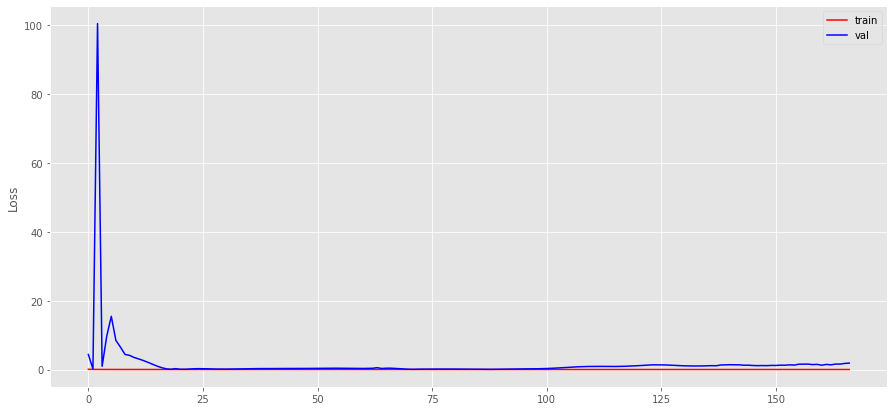

In [81]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 1.34154324493095
MSE = 2.139290247421047
RMSE = 1.462631275277897
R2 Score = -6.363000410235945


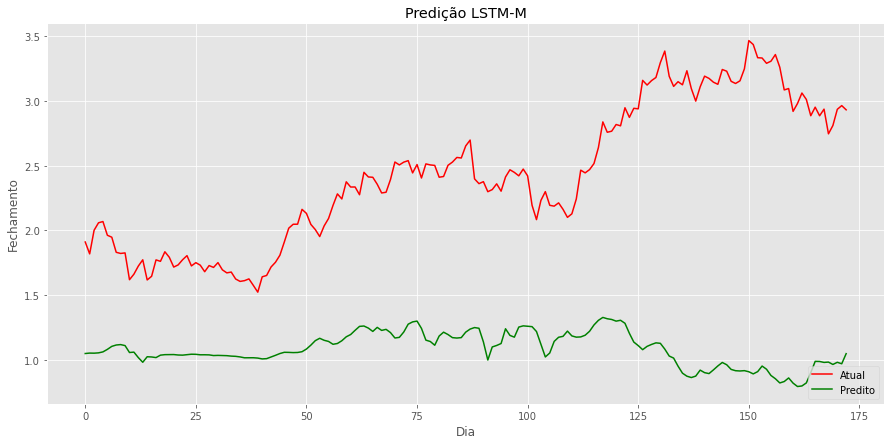

In [82]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R2 Score = {}'.format(r2_value))
plot_data(true,predicted)

## Validação Cruzada

In [83]:
# Menor número de épocas
num_epochs = 80

In [84]:
# Extraindo as séries
series = df[features] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(2628, 4)
                   Close          Open           Low          High
Date                                                              
2021-11-26  53569.765625  58960.285156  53569.765625  59183.480469
2021-11-27  54815.078125  53736.429688  53668.355469  55329.257812
2021-11-28  57248.457031  54813.023438  53576.734375  57393.843750
2021-11-29  57806.566406  57291.906250  56792.527344  58872.878906
2021-12-01  57172.332031  56865.179688  56865.179688  57683.578125


In [85]:
# Normalização
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.00414359, 0.00428907, 0.00424271, 0.00373944],
       [0.00365546, 0.00415543, 0.00364887, 0.00357446],
       [0.00321557, 0.00366922, 0.00321734, 0.00315122],
       ...,
       [0.84688283, 0.81095184, 0.80659687, 0.83382719],
       [0.85516477, 0.84774534, 0.85516606, 0.85539442],
       [0.84575319, 0.84141154, 0.85626335, 0.83805209]])

### Função para validação forward walk usando lote 

In [86]:
def cross_val_forward_walk_batch(splits,split_size, series):
    cross_val_results = list()
    for i in range(splits):
        train = series[:(3+i)*split_size]
        test = series[(3+i)*split_size:(4+i)*split_size]
        X_train,Y_train = to_sequential_data(train, timesteps)
        start = time.time()
        history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
        end = time.time()  
        
        mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
        print("Split "+str(i+1))
        print('MAE = {}'.format(mae))
        print('MSE = {}'.format(mse))
        print('RMSE = {}'.format(rmse))
        print('R-Squared Score = {}'.format(r2_value))
        plot_data(true,predicted)
        cross_val_results.append([mae, mse,rmse,r2_value,end-start])
        
    return cross_val_results

Split 1
MAE = 0.0005553361755678432
MSE = 3.459592598586798e-07
RMSE = 0.0005881830156156158
R-Squared Score = -1.7340526065170172


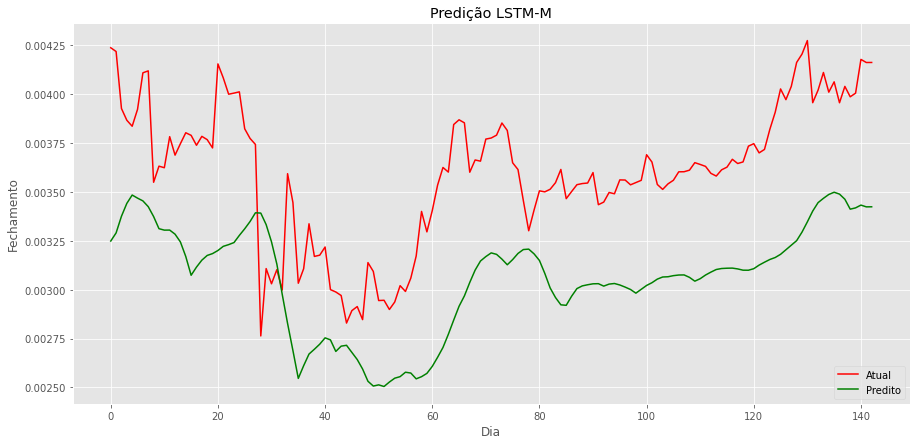

Split 2
MAE = 0.0010178648198566355
MSE = 1.303133744027079e-06
RMSE = 0.001141548835585705
R-Squared Score = -0.35422728407240633


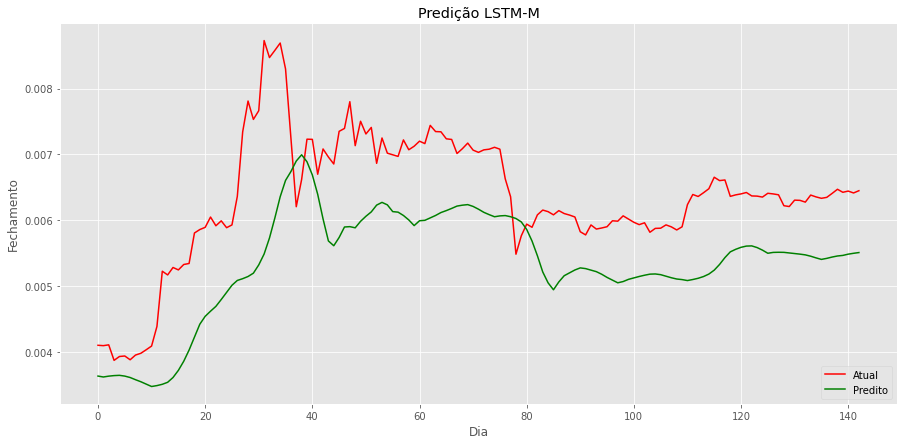

Split 3
MAE = 0.0016905910681336974
MSE = 3.532477423491935e-06
RMSE = 0.0018794886069066594
R-Squared Score = 0.3748791567754022


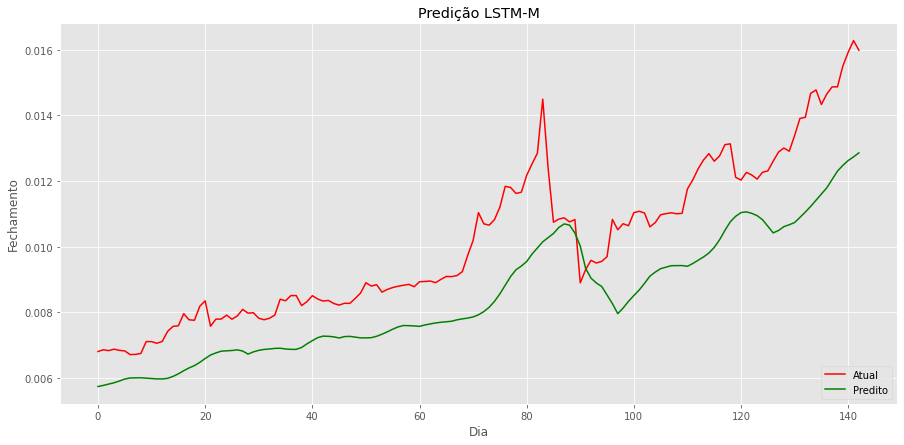

Split 4
MAE = 0.0026863324211076085
MSE = 1.4181891584959897e-05
RMSE = 0.0037658852325794393
R-Squared Score = 0.8504554187137426


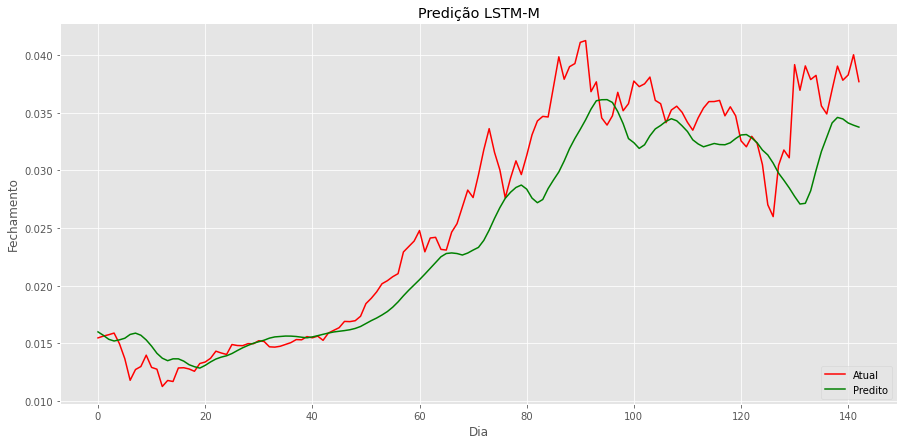

Split 5
MAE = 0.021455325872173945
MSE = 0.0007260490090151073
RMSE = 0.026945296602841604
R-Squared Score = 0.8312111661311439


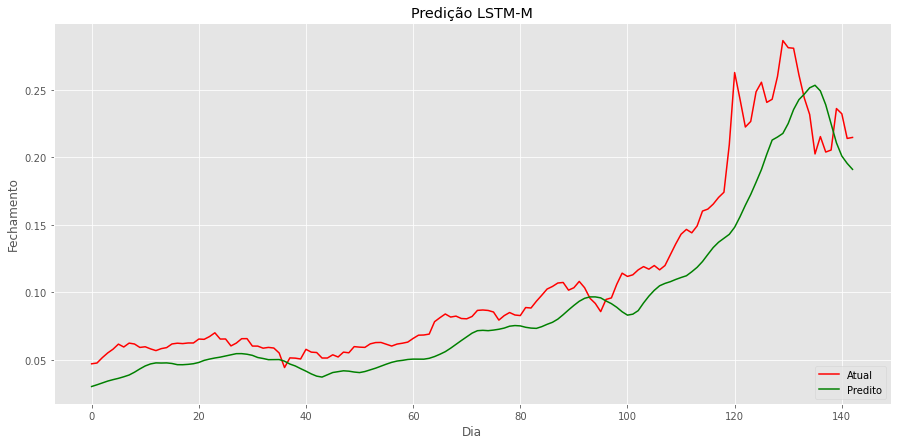

In [87]:
#Chamada da função
splits = 5
split_size = 150
cross_val_results = cross_val_forward_walk_batch(splits,split_size, series)

In [88]:
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Média MAE = {}".format(CV_temp['MAE'].mean()))
print("Média MSE = {}".format(CV_temp['MSE'].mean()))
print("Média RMSE = {}".format(CV_temp['RMSE'].mean()))
print("Média R2 = {}".format(CV_temp['R2_Score'].mean()))


Média MAE = 0.0054810900713679455
Média MSE = 0.00014908249420548898
Média RMSE = 0.006864080458705804
Média R2 = -0.0063468297938269694
